In [13]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [14]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수

resolution = 50        # 시뮬레이션 해상도
design_region_resolution = 50

nfreq = 50             # 추출할 주파수 개수
df = fmax-fmin         # 주파수 대역폭

# df = 0
# nfreq = 1

In [40]:
tag_bot = 0.5
tag_side = 4
tsio2 = 4
monitor_position = 0.5 * 2
monitor_blank = 0.5 * 0.1
tpml = 0.4

width_ag = 0.2
width_sio2 = 2
width_bot_ag = round(width_ag + width_sio2 + width_ag,2)
design_region_width = round(width_bot_ag, 3)
design_region_height = 0.5

# 시뮬레이션 셀 크기
Sx = tpml + width_bot_ag + tpml
Sy = round(tpml + tag_bot + tag_side + design_region_height + monitor_position + monitor_blank + tpml, 3)
cell_size = mp.Vector3(Sx, Sy)

# 재료
SiO2 = mp.Medium(index=1.45)
TiO2 = mp.Medium(index=2.6)
Air = mp.Medium(index=1.0)

# 디자인 변수 격자
Nx = int(design_region_resolution * design_region_width) + 1
Ny = 1  # 평면 구조

# 위치 계산
y_bottom = -Sy / 2
center_y_ag = y_bottom + tpml + tag_bot / 2
center_y_sio2 = y_bottom + tpml + tag_bot + tsio2 / 2
center_y_design = y_bottom + tpml + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tpml + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tpml + tag_bot + 1 / fcen
center_Ag_x_position = design_region_width / 2 - width_ag / 2

boundary_layers = [
    # mp.Absorber(tpml, direction=mp.X),
    mp.PML(tpml, direction=mp.Y, side=mp.Low),
    mp.PML(tpml, direction=mp.Y, side=mp.High)
]

In [77]:
# 셀 크기 설정
# cell_size = mp.Vector3(Sx*3, Sy)
cell_size = mp.Vector3(width_bot_ag*3, Sy)

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]


In [92]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

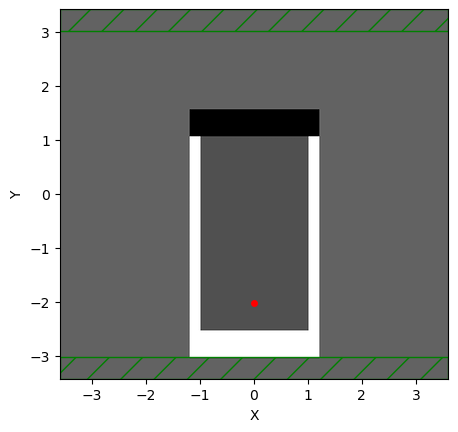

In [93]:
num_sources = 1
spacing = 10 / resolution  

offsets = [ (i - (num_sources - 1) // 2) * spacing for i in range(num_sources) ]

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(offset, center_y_source_position, 0)
    )
    for offset in offsets
]



sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        extra_materials=[Ag],
        k_point=mp.Vector3(0,0,0)
    )
    for src in sources
]

sims[0].plot2D()

In [94]:
L       = sims[0].cell_size.x     # = Sx*3 = 9.6
lambda0 = 1/ fcen                 # = 0.64
m_max   = int(np.floor(L / lambda0))  # = floor(9.6/0.64) = 15
total_modes = 2*m_max + 1             # = 31
print(total_modes)  # → 31

29


-----------
Initializing structure...
time for choose_chunkdivision = 6.8903e-05 s
Working in 2D dimensions.
Computational cell is 7.2 x 6.86 x 0 with resolution 50
     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.093179 s
lorentzian susceptibility: frequency=16.365, gamma=1

run 0 finished at t = 200.0 (20000 timesteps)
     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

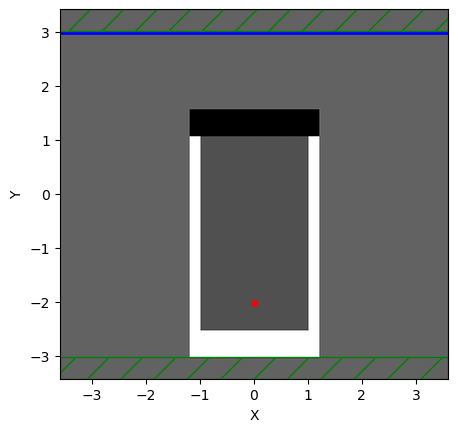

In [81]:
monitor_position_J = mp.Vector3(0, center_y_monitor_position)
monitor_size = mp.Vector3(Sx*3, 0)

dft_monitor = sims[0].add_dft_fields([mp.Ez], fcen,0,1, center = monitor_position_J, size = monitor_size, yee_grid=True)

sims[0].run(until=200)


Ez_dft =sims[0].get_dft_array(dft_monitor,mp.Ez,0)

sims[0].plot2D()

In [114]:
design_region_width*3

7.199999999999999

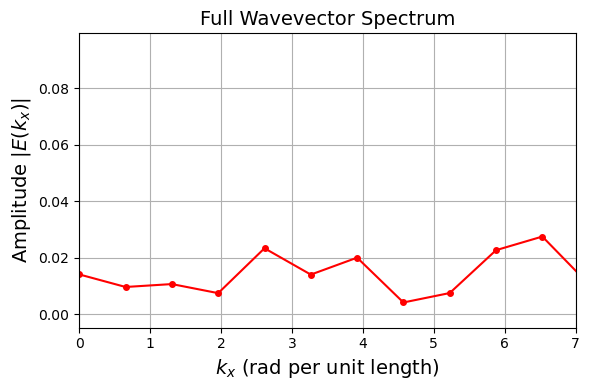

In [119]:
import numpy as np
import matplotlib.pyplot as plt

# (1) FFT 및 파수 계산
N        = len(Ez_dft)
dx       = 1.0 / resolution
E_k      = np.fft.fftshift(np.fft.fft(Ez_dft)) / N
kx_cycles = np.fft.fftshift(np.fft.fftfreq(N, d=dx))  # 사이클/단위길이
kx       = 2 * np.pi * kx_cycles                     # rad/단위길이

# (2) 전체 스펙트럼 플롯 (마스크 없이)
plt.figure(figsize=(6,4))
plt.plot(kx, np.abs(E_k), '-ro', markersize=4)
plt.xlabel(r"$k_x\ \mathrm{(rad\ per\ unit\ length)}$", fontsize=14)
plt.ylabel(r"Amplitude $|E(k_x)|$",                   fontsize=14)
plt.title("Full Wavevector Spectrum",                 fontsize=14)
plt.xlim(0, 7)    # 필요에 따라 범위 조정
plt.grid(True)
plt.tight_layout()
plt.show()


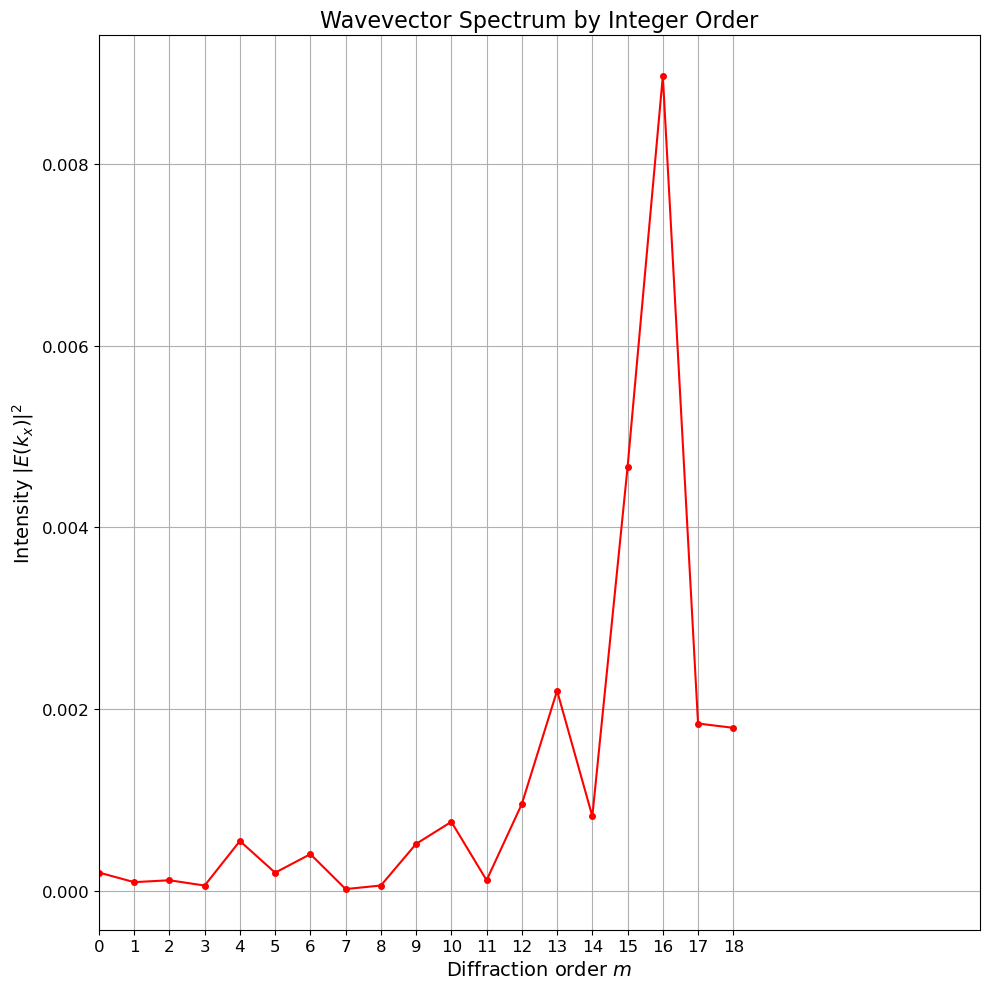

In [135]:
import numpy as np
import matplotlib.pyplot as plt

# (1) FFT 및 파수 계산
N         = len(Ez_dft)
dx        = 1.0 / resolution
E_k       = np.fft.fftshift(np.fft.fft(Ez_dft)) / N
kx_cycles = np.fft.fftshift(np.fft.fftfreq(N, d=dx))   # cycle / unit length
kx        = 2 * np.pi * kx_cycles                      # rad / unit length

# (2) 차수 m 계산
Delta_k = 2 * np.pi / (N * dx)   # DFT 빈 간격
m_vals  = kx / Delta_k           # m = kx/Δk

# (3) 전파 모드만 (원하면 주석 해제)
mask         = np.abs(kx) <= k0
m_prop       = m_vals[mask]
amplitude    = np.abs(E_k)       # 진폭
amp_prop     = amplitude[mask]**2 # 강도 (원하면 제곱)

# m_prop       = m_vals
# amplitude    = np.abs(E_k)       # 진폭
# amp_prop     = amplitude**2 # 강도 (원하면 제곱)


# (4) 플롯: 정수 차수 m 축
plt.figure(figsize=(10,10))
plt.plot(m_prop, amp_prop, 'ro-', markersize=4)
plt.xlabel("Diffraction order $m$", fontsize=14)
plt.ylabel("Intensity $|E(k_x)|^2$", fontsize=14)
plt.title("Wavevector Spectrum by Integer Order", fontsize=16)
plt.xticks(np.arange(np.floor(m_prop.min()), np.ceil(m_prop.max())+1, 1), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
# plt.xlim(m_prop.min()-0.5, m_prop.max()+0.5)
plt.xlim(-4,4)
plt.xlim(0,25)
plt.tight_layout()
plt.show()
